<a href="https://colab.research.google.com/github/itz-rakshitha5/Generative-AI/blob/main/GAN_Implementation_to_generate_handwritten_digits%5BExp_2%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 59.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

In [3]:
class Generator (nn.Module):
  def __init__(self, z_dim):
    super(Generator, self).__init__()
    self.fc1 = nn.Linear(z_dim, 128)
    self.fc2 = nn.Linear(128, 256)
    self.fc3 = nn.Linear(256, 512)
    self.fc4 = nn.Linear(512, 1024)
    self.fc5 = nn.Linear(1024, 28*28)
    self.relu = nn.ReLU()
    self.tanh = nn.Tanh()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.relu(self.fc3(x))
    x = self.relu(self.fc4(x))
    x = self.tanh(self.fc5(x))
    return x.view(x.size(0), 1 , 28, 28)

In [4]:
class Critic(nn.Module):
  def __init__(self):
    super(Critic, self).__init__()
    self.fc1 = nn.Linear(784, 1024)
    self.fc2 = nn.Linear(1024, 512)
    self.fc3 = nn.Linear(512, 256)
    self.fc4 = nn.Linear(256, 1)
    self.leaky_relu = nn.LeakyReLU(0.2)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.leaky_relu(self.fc1(x))
    x = self.leaky_relu(self.fc2(x))
    x = self.leaky_relu(self.fc3(x))
    return self.fc4(x)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 504kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.62MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [6]:
def wasserstein_loss(y_true, y_pred):
  return torch.mean(y_true * y_pred)

In [7]:
def compute_gradient_penalty(critic, real_images, fake_images, device):
  batch_size, C, H, W = real_images.size()
  epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
  interpolated_images = epsilon * real_images + (1 - epsilon) * fake_images
  interpolated_images.requires_grad_(True)

  critic_interpolated_output = critic(interpolated_images)

  # Assign critic_interpolated_output to critic_outputs
  critic_outputs = critic_interpolated_output

  gradient = torch.autograd.grad(
      outputs=critic_interpolated_output,
      inputs=interpolated_images,
      # Use critic_outputs instead of critic_interpolated_output here
      grad_outputs=torch.ones_like(critic_outputs),
      create_graph = True, retain_graph=True,
  )[0]


  gradient = gradient.view(batch_size, -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = ((gradient_norm-1)**2).mean()

  return penalty

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [0/100], Critic Loss: -9.569258689880371, Generator Loss: -1.0874004364013672


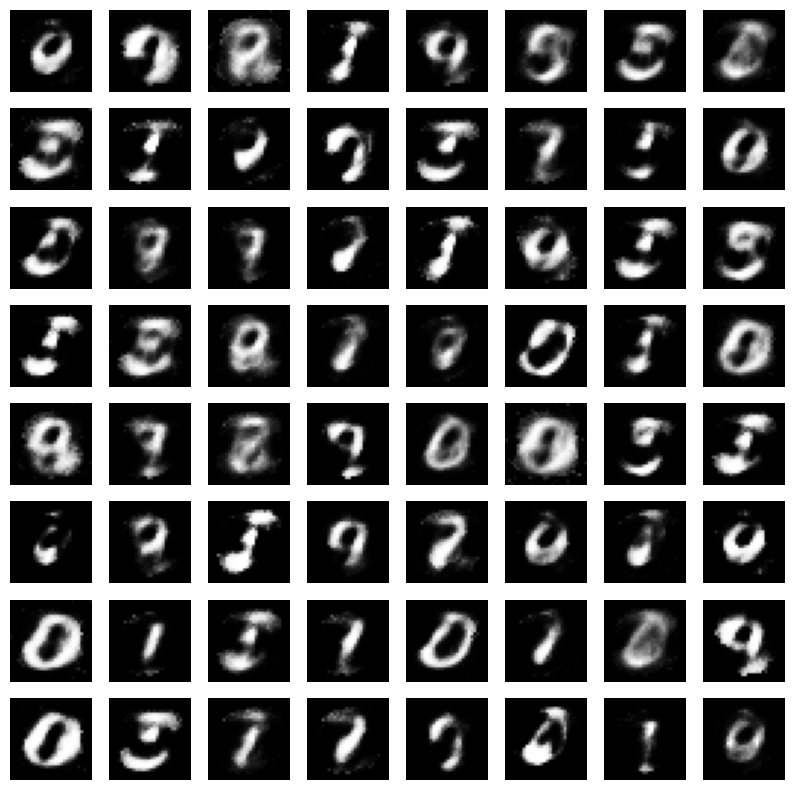

Epoch [1/100], Critic Loss: -8.295455932617188, Generator Loss: 6.902661323547363
Epoch [2/100], Critic Loss: -9.654605865478516, Generator Loss: 7.992100715637207
Epoch [3/100], Critic Loss: -9.30009937286377, Generator Loss: 7.72736930847168
Epoch [4/100], Critic Loss: -8.140652656555176, Generator Loss: 4.947476863861084
Epoch [5/100], Critic Loss: -6.093195915222168, Generator Loss: 3.7717461585998535
Epoch [6/100], Critic Loss: -6.998607635498047, Generator Loss: 2.9565672874450684
Epoch [7/100], Critic Loss: -6.980229377746582, Generator Loss: 2.2107229232788086
Epoch [8/100], Critic Loss: -6.536076545715332, Generator Loss: 2.7329797744750977
Epoch [9/100], Critic Loss: -6.404472827911377, Generator Loss: 3.5295915603637695
Epoch [10/100], Critic Loss: -5.318197250366211, Generator Loss: 2.3937888145446777


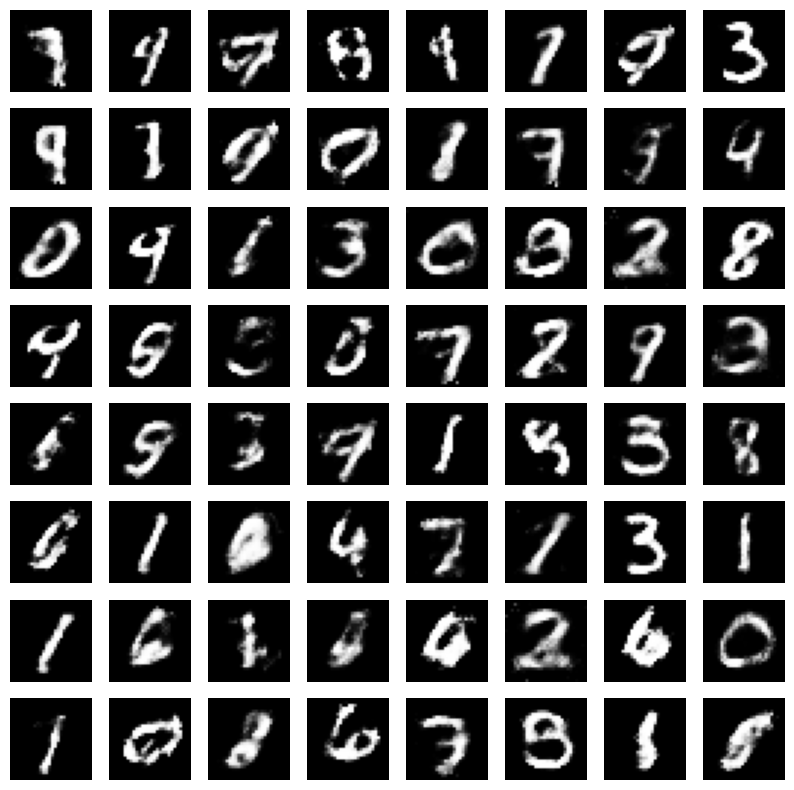

Epoch [11/100], Critic Loss: -5.807486534118652, Generator Loss: 3.8419628143310547
Epoch [12/100], Critic Loss: -6.389854431152344, Generator Loss: 2.95261287689209
Epoch [13/100], Critic Loss: -6.172804832458496, Generator Loss: 3.395326614379883
Epoch [14/100], Critic Loss: -5.287576675415039, Generator Loss: 2.6665570735931396
Epoch [15/100], Critic Loss: -6.097763538360596, Generator Loss: 4.912020683288574
Epoch [16/100], Critic Loss: -5.1068501472473145, Generator Loss: 3.034475803375244
Epoch [17/100], Critic Loss: -5.047779083251953, Generator Loss: 3.0312538146972656
Epoch [18/100], Critic Loss: -5.559985637664795, Generator Loss: 3.4376418590545654
Epoch [19/100], Critic Loss: -4.096129417419434, Generator Loss: 4.691428184509277
Epoch [20/100], Critic Loss: -5.130457878112793, Generator Loss: 3.3008487224578857


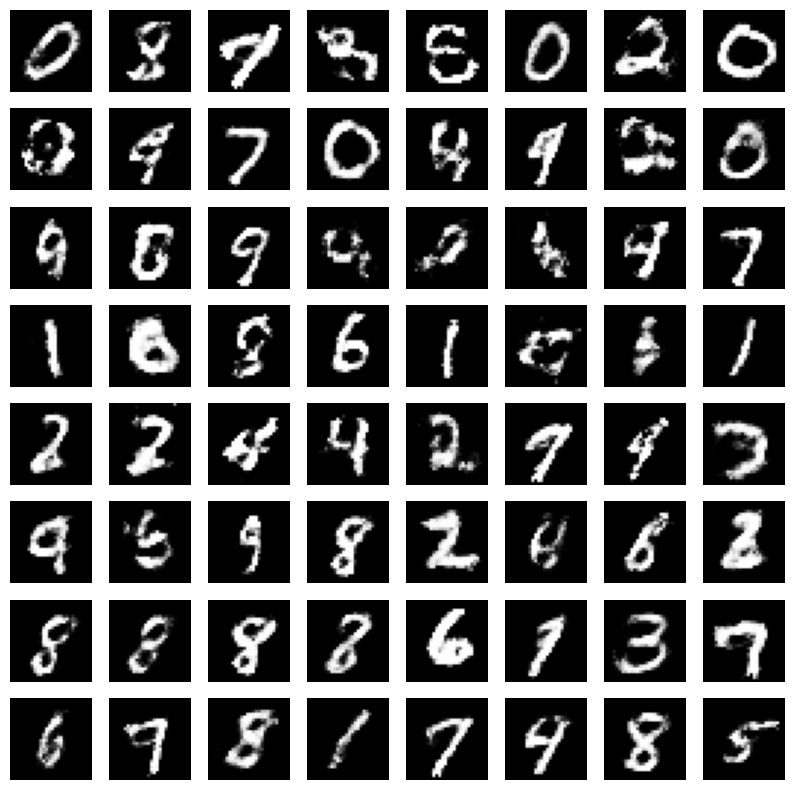

Epoch [21/100], Critic Loss: -4.35886812210083, Generator Loss: 5.664215564727783
Epoch [22/100], Critic Loss: -4.3802900314331055, Generator Loss: 5.565199851989746
Epoch [23/100], Critic Loss: -4.131316184997559, Generator Loss: 4.319450378417969
Epoch [24/100], Critic Loss: -4.659023284912109, Generator Loss: 2.966902256011963
Epoch [25/100], Critic Loss: -4.654688358306885, Generator Loss: 5.832074165344238
Epoch [26/100], Critic Loss: -3.56488299369812, Generator Loss: 3.9268314838409424
Epoch [27/100], Critic Loss: -4.264835834503174, Generator Loss: 5.27562141418457
Epoch [28/100], Critic Loss: -4.872955799102783, Generator Loss: 4.445682525634766
Epoch [29/100], Critic Loss: -3.3532886505126953, Generator Loss: 4.230724334716797
Epoch [30/100], Critic Loss: -4.02266788482666, Generator Loss: 4.55645751953125


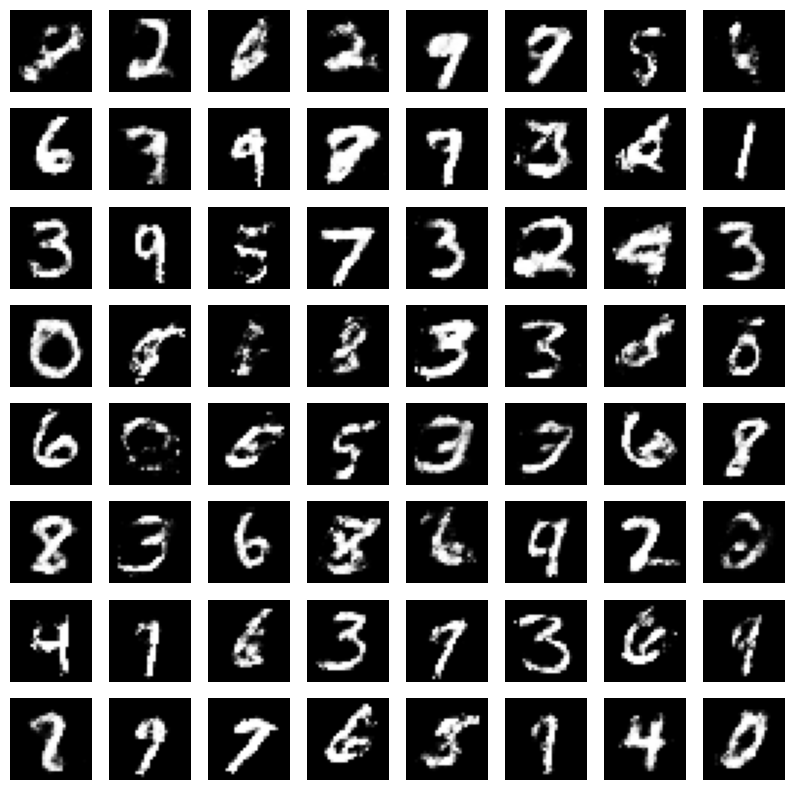

Epoch [31/100], Critic Loss: -3.9208881855010986, Generator Loss: 3.30336856842041
Epoch [32/100], Critic Loss: -4.0174241065979, Generator Loss: 5.045330047607422
Epoch [33/100], Critic Loss: -3.3499722480773926, Generator Loss: 4.14572286605835
Epoch [34/100], Critic Loss: -4.2407002449035645, Generator Loss: 5.430811882019043
Epoch [35/100], Critic Loss: -3.595350742340088, Generator Loss: 3.806912422180176
Epoch [36/100], Critic Loss: -2.999568462371826, Generator Loss: 2.0126090049743652
Epoch [37/100], Critic Loss: -4.364104270935059, Generator Loss: 4.1326799392700195
Epoch [38/100], Critic Loss: -4.487382888793945, Generator Loss: 3.708163261413574
Epoch [39/100], Critic Loss: -3.123849868774414, Generator Loss: 1.3914000988006592
Epoch [40/100], Critic Loss: -3.97979736328125, Generator Loss: 6.328747272491455


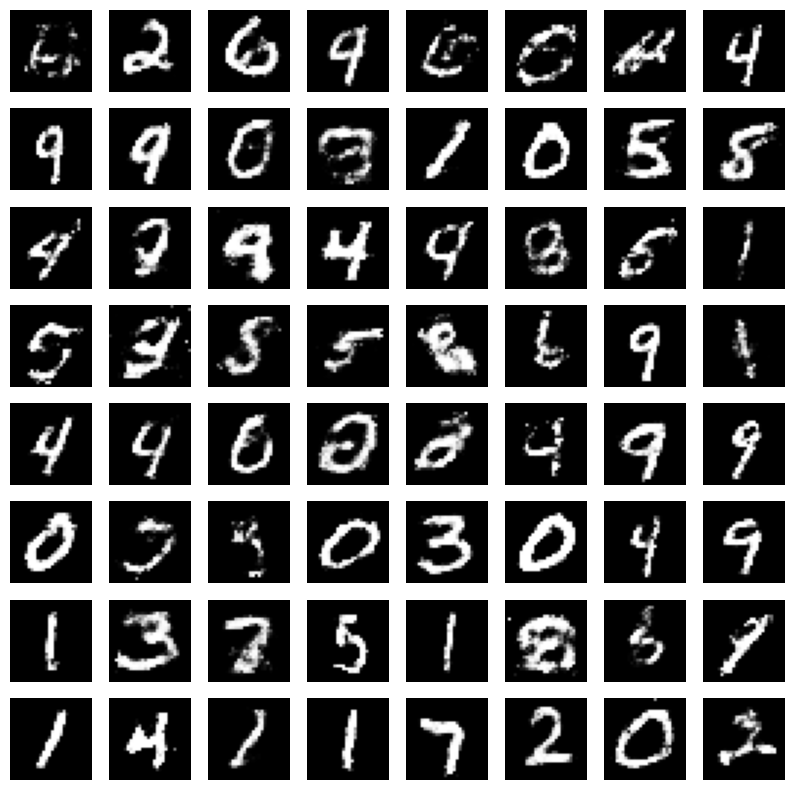

Epoch [41/100], Critic Loss: -3.9543421268463135, Generator Loss: 2.973933219909668
Epoch [42/100], Critic Loss: -2.6768388748168945, Generator Loss: 2.8856215476989746
Epoch [43/100], Critic Loss: -3.9427504539489746, Generator Loss: 2.640352725982666
Epoch [44/100], Critic Loss: -3.3132102489471436, Generator Loss: 4.441076278686523
Epoch [45/100], Critic Loss: -3.630642890930176, Generator Loss: 4.1212158203125
Epoch [46/100], Critic Loss: -4.219815731048584, Generator Loss: 6.443528652191162
Epoch [47/100], Critic Loss: -3.9051027297973633, Generator Loss: 3.3053197860717773
Epoch [48/100], Critic Loss: -3.2799901962280273, Generator Loss: 3.5024406909942627
Epoch [49/100], Critic Loss: -3.523728370666504, Generator Loss: 4.510004043579102
Epoch [50/100], Critic Loss: -3.117105722427368, Generator Loss: 4.039922714233398


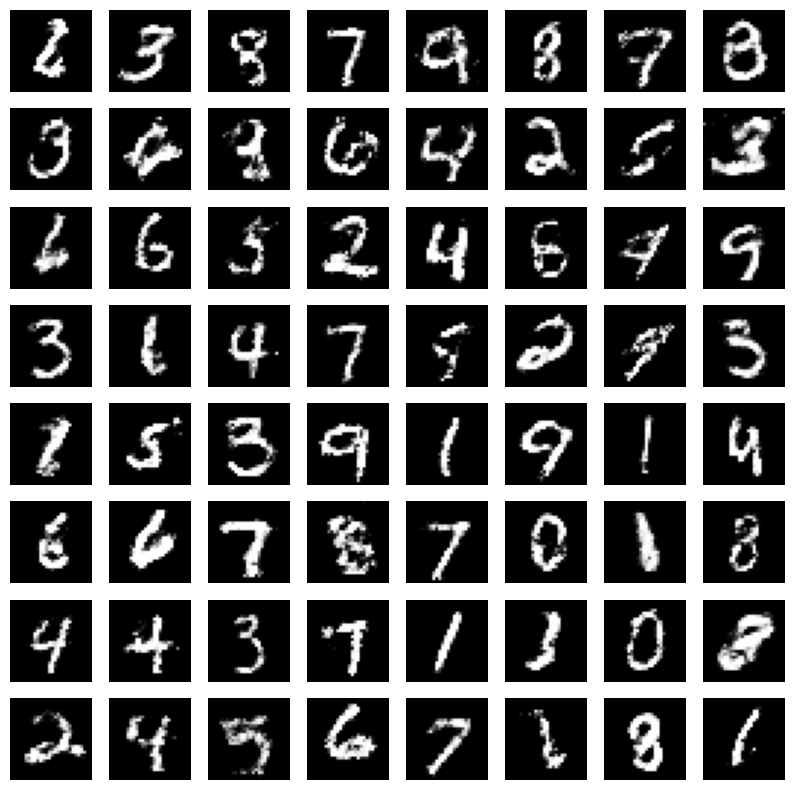

Epoch [51/100], Critic Loss: -3.412379264831543, Generator Loss: 1.0926541090011597
Epoch [52/100], Critic Loss: -3.920400381088257, Generator Loss: 1.8120520114898682
Epoch [53/100], Critic Loss: -2.6290435791015625, Generator Loss: 2.345142364501953
Epoch [54/100], Critic Loss: -3.439544200897217, Generator Loss: 2.477931022644043
Epoch [55/100], Critic Loss: -2.9866764545440674, Generator Loss: 3.267622470855713
Epoch [56/100], Critic Loss: -3.1353461742401123, Generator Loss: 1.845346450805664
Epoch [57/100], Critic Loss: -2.9999945163726807, Generator Loss: 3.1996958255767822
Epoch [58/100], Critic Loss: -3.713827133178711, Generator Loss: 1.8745594024658203
Epoch [59/100], Critic Loss: -3.7669224739074707, Generator Loss: 2.3614840507507324
Epoch [60/100], Critic Loss: -2.9090843200683594, Generator Loss: 1.9844822883605957


In [ ]:
z_dim = 100
lr = 0.00005
n_critic = 5
lamba_gp = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator(z_dim).to(device)
critic = Critic().to(device)

optim_gen = optim.Adam(generator.parameters(), lr=lr, betas=(0.0, 0.9))
optim_critic = optim.Adam(critic.parameters(), lr=lr, betas=(0.0, 0.9))

epochs = 100
for epoch in range (epochs):
  for i, (real_images, _) in enumerate(train_loader):
    real_images = real_images.to(device)
    batch_size = real_images.size(0)

    for _ in range(n_critic):
      z = torch.randn(batch_size, z_dim).to(device)
      fake_images = generator(z)
      critic_real= critic(real_images)
      critic_fake= critic(fake_images)

      gradient_penalty = compute_gradient_penalty(critic, real_images, fake_images, device)

      critic_loss = -torch.mean(critic_real) + torch.mean(critic_fake) + lamba_gp * gradient_penalty

      optim_critic.zero_grad()
      critic_loss.backward()
      optim_critic.step()

    z = torch.randn(batch_size, z_dim).to(device)
    fake_images = generator(z)
    critic_fake = critic(fake_images)

    gen_loss = -torch.mean(critic_fake)

    optim_gen.zero_grad()
    gen_loss.backward()
    optim_gen.step()

  print(f"Epoch [{epoch}/{epochs}], Critic Loss: {critic_loss.item()}, Generator Loss: {gen_loss.item()}")

  if epoch % 10 == 0:
    with torch.no_grad():
      test_z = torch.randn(64, z_dim).to(device)
      generated_images = generator(test_z)
      generated_images = generated_images.cpu().data
      generated_images = generated_images.view(64, 28, 28)

      plt.figure(figsize=(10, 10))
      for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
      plt.show()